<!-- 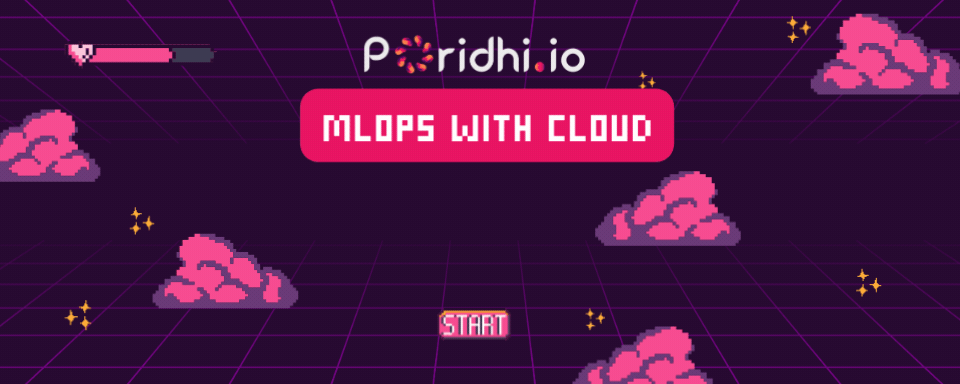 -->
<!-- 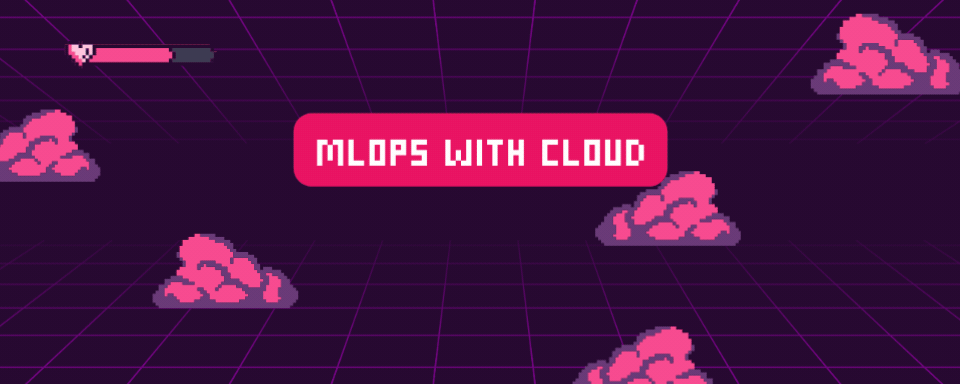 -->
<div style="text-align:center;">
    <img src="attachment:f3ca8e66-ff66-4a18-926c-f69deebf987f.gif" width="1000"/>
</div>

Welcome to the first notebook of this lab. In this notebook, we'll set up the staging data store and upload the raw dataset needed for training the model. 
* You will be using the following dataset from kaggle, **Electric Power Consumption** \
  The details about the dataset can be found in the following URL, \
**Source:** https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption/data 


A detailed discussion about the dataset at the end of this notebook

# Setting up boto3 with AWS credentials
You need to set up a boto3 client to access the S3 buckets which are necessary for this model training lab.

In [1]:
import boto3
import pandas as pd
s3_client = boto3.resource('s3')

## Set up the AWS credentials with boto3 clients
Add the credentials from your running lab's webpage \
(You can also try to save them as environment variables)

In [2]:
# Create an S3 resource

s3_client = boto3.resource(
    service_name='s3',
    region_name='ap-southeast-1',
    aws_access_key_id='', 
    aws_secret_access_key=''
)

### Check The S3 Buckets Created with Pulumi a Little While Ago

In [3]:
# List all bucket names
for bucket in s3_client.buckets.all():
    print(bucket.name)

featurestorebucket-poridhi-12345-5bd4639
modelstorebucket-poridhi-12345-f772b84
resultsstorebucket-poridhi-12345-00a29f5
stagingdatastorebucket-poridhi-12345-bbcdbd9


Let's understand the objective behind creating these data stores for this ML task. Here's a short overview of these data stores,
* You will use the ***stagingdatastorebucket*** to utilize as a staging data store where all the raw data will be stored from the sources. In this scenario, you won't connect any data connectors, API, databases or any other sources but this data engineering practice would be common throughout the course and other labs.
  
* After ingesting the raw dataset into our transformation script you would perform some transformations and feature engineering/creation tasks. After processing the raw dataset and computing the necessary features for the ML model training, the transformed data would be stored in ***featurestorebucket***. We will discuss a lot about this in the upcoming section

* Before ingesting the data to the model training process, we would ingest the features from feature store to the ***modelstorebucket***. Then, we will ingest the data from modeldatastore bucket to the model training function

* Finally, ***resultsstorebucket*** would be used to store the outputs/results/predictions driven by the model.

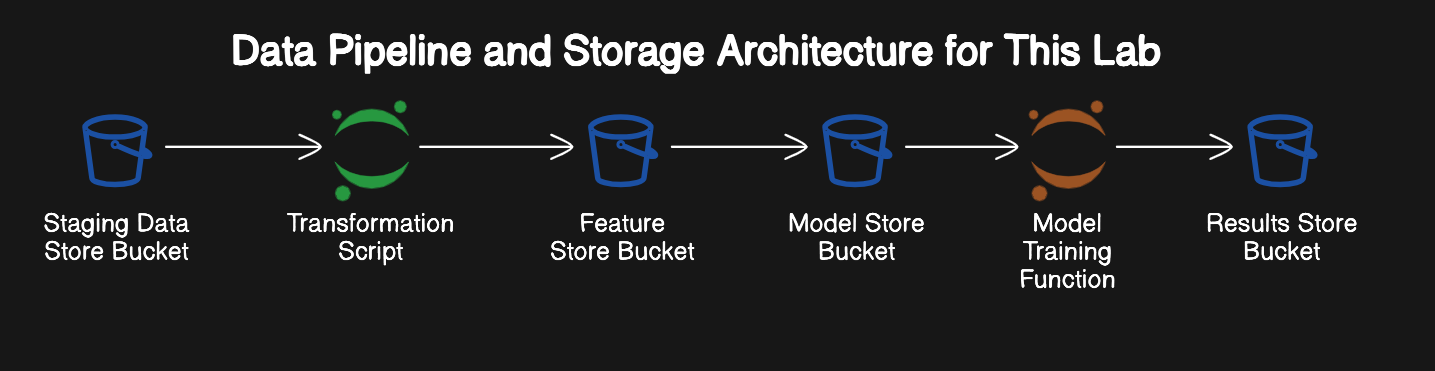

# Upload the Raw Dataset to the Staging Data Store Bucket
In real scenarios, you often have to have an initial data store to be used as the staging area where the raw dataset should be stored. In general, the whole process of ingesting, storing and transforming the data should be automated with tools like Apache Airflow, Dagster, Dbt, etc. And, there would be more sophisticated and robust data storage solutions like data warehouses or object storage provided by many many vendors. 
> We will discuss and demonstrate orchestration tools like Apache Airflow, and Dagster later in this course. But for this lab, we want to grow intuitions around the data storage necessities for each task and best practices around them.

This staging data store is crucial to support the data transformation tasks and establish the data lineage.

In [4]:
local_file_path = './1-raw-dataset/powerconsumption.csv'
bucket_name = 'stagingdatastorebucket-poridhi-12345-bbcdbd9'
file_key = 'raw-dataset.csv'

### Upload the raw dataset to the staging datastore

In [5]:
s3_client.meta.client.upload_file(local_file_path, bucket_name, 'staging-directory/raw-dataset.csv')

### Check if the operation is done smoothly

In [6]:
# List all objects in the bucket
for obj in s3_client.Bucket(bucket_name).objects.all():
    print(obj.key)

staging-directory/raw-dataset.csv


You can also check in AWS console,

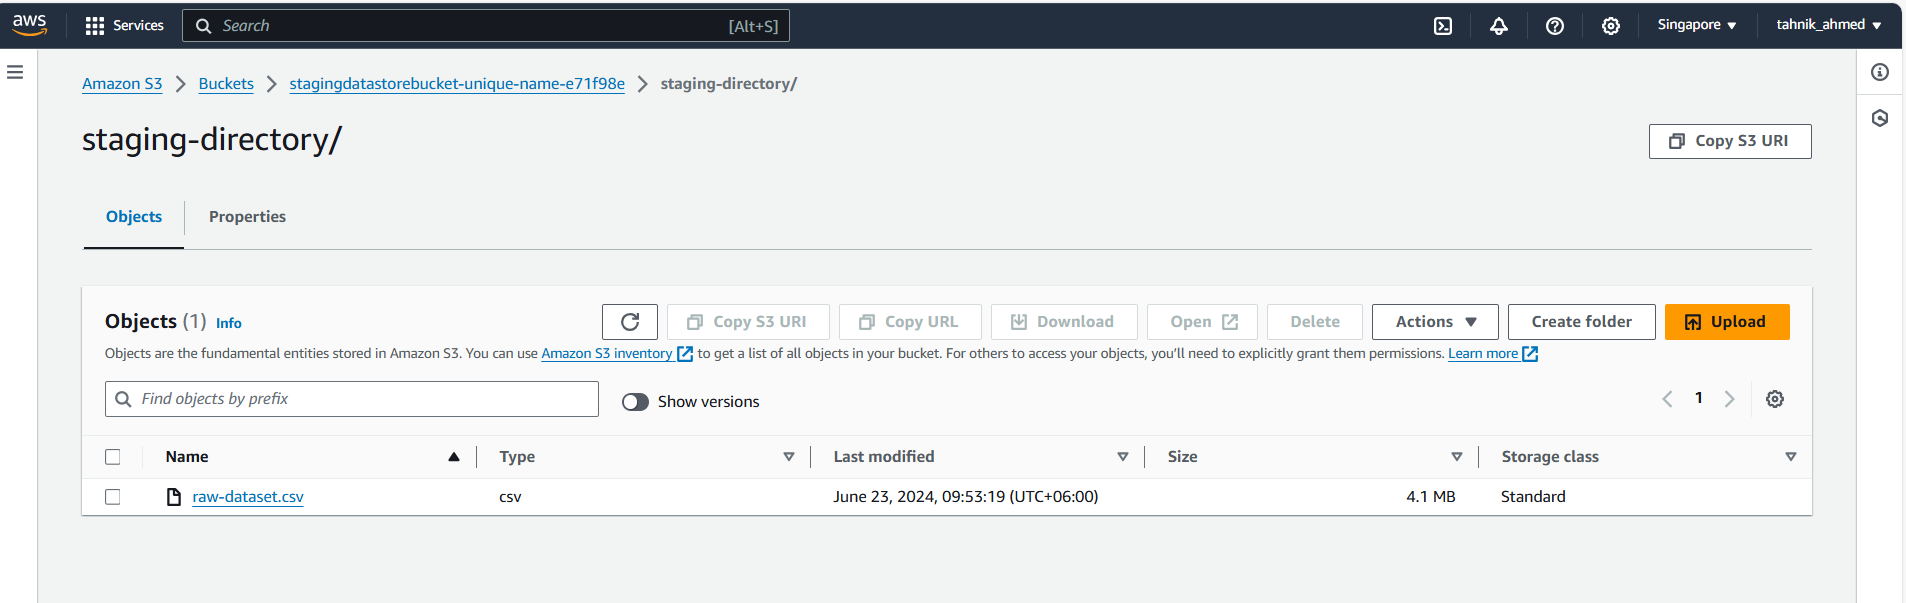

# Importing the Necessary Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import plotly.graph_objects as go
from datetime import datetime
!pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Loading the Dataset from Data Staging Store Bucket

In [8]:
import ray

ds = ray.data.read_csv("s3://stagingdatastorebucket-poridhi-12345-bbcdbd9/staging-directory/raw-dataset.csv")
ds.show(limit=5)
df = ds.to_pandas()

2024-09-01 19:32:18,517	INFO worker.py:1598 -- Connecting to existing Ray cluster at address: 10.0.1.175:6379...
2024-09-01 19:32:18,531	INFO worker.py:1774 -- Connected to Ray cluster. View the dashboard at 10.0.1.175:8265 
2024-09-01 19:32:20,338	INFO dataset.py:2416 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-09-01 19:32:20,348	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:32:20,349	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> LimitOperator[limit=5]


[dataset]: Run `pip install tqdm` to enable progress reporting.


2024-09-01 19:32:22,947	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:32:22,949	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV]


{'Datetime': '1/1/2017 0:00', 'Temperature': 6.559, 'Humidity': 73.8, 'WindSpeed': 0.083, 'GeneralDiffuseFlows': 0.051, 'DiffuseFlows': 0.119, 'PowerConsumption_Zone1': 34055.6962, 'PowerConsumption_Zone2': 16128.87538, 'PowerConsumption_Zone3': 20240.96386}
{'Datetime': '1/1/2017 0:10', 'Temperature': 6.414, 'Humidity': 74.5, 'WindSpeed': 0.083, 'GeneralDiffuseFlows': 0.07, 'DiffuseFlows': 0.085, 'PowerConsumption_Zone1': 29814.68354, 'PowerConsumption_Zone2': 19375.07599, 'PowerConsumption_Zone3': 20131.08434}
{'Datetime': '1/1/2017 0:20', 'Temperature': 6.313, 'Humidity': 74.5, 'WindSpeed': 0.08, 'GeneralDiffuseFlows': 0.062, 'DiffuseFlows': 0.1, 'PowerConsumption_Zone1': 29128.10127, 'PowerConsumption_Zone2': 19006.68693, 'PowerConsumption_Zone3': 19668.43373}
{'Datetime': '1/1/2017 0:30', 'Temperature': 6.121, 'Humidity': 75.0, 'WindSpeed': 0.083, 'GeneralDiffuseFlows': 0.091, 'DiffuseFlows': 0.096, 'PowerConsumption_Zone1': 28228.86076, 'PowerConsumption_Zone2': 18361.09422, 'Pow

In [9]:
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# Exploratory Data Analysis on the Raw Dataset

### Plotly Visualization

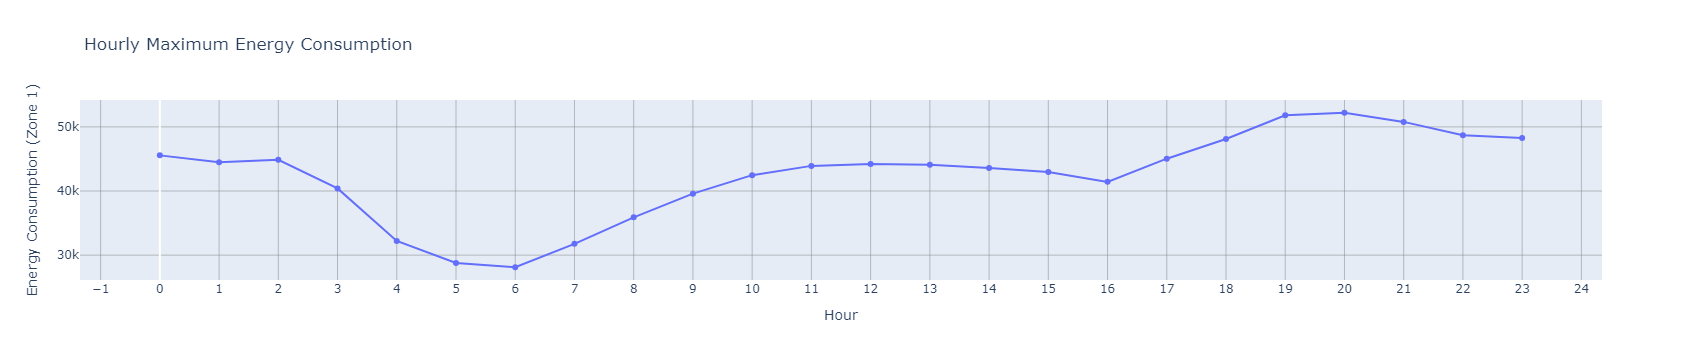

In [138]:
import plotly.express as px

# Calculate the hourly maximum energy consumption
hourly_max = df.groupby('Hour')['PowerConsumption_Zone1'].max().reset_index()

# Create the plot with Plotly Express
fig = px.line(hourly_max, x='Hour', y='PowerConsumption_Zone1', markers=True,
              title='Hourly Maximum Energy Consumption',
              labels={'PowerConsumption_Zone1': 'Energy Consumption (Zone 1)'})

# Customize the layout for grid and ticks
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        title='Hour',
        gridcolor='grey',  # Customize grid line color
        gridwidth=0.5  # Customize grid line width
    ),
    yaxis=dict(
        title='Energy Consumption (Zone 1)',
        gridcolor='grey',  # Customize grid line color
        gridwidth=0.5  # Customize grid line width
    ),
    showlegend=False
)

# Show the plot
fig.show()

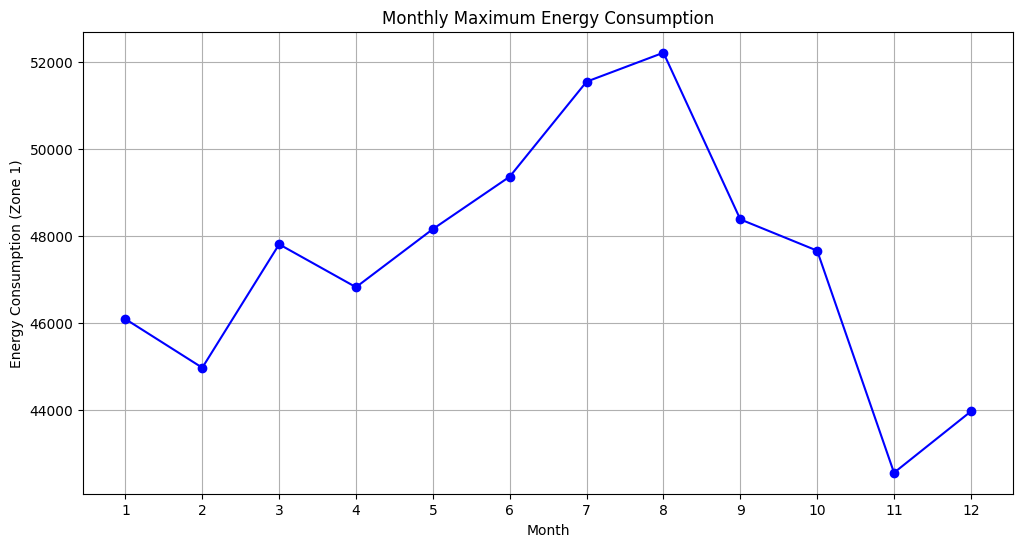

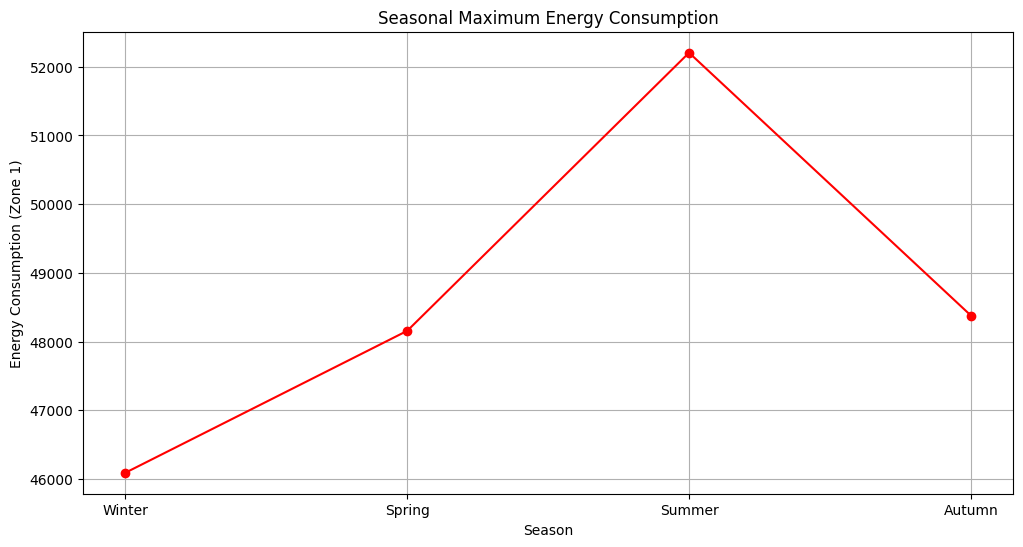

In [139]:
# Monthly maximum energy consumption
monthly_max = df.groupby('Month')['PowerConsumption_Zone1'].max().reset_index()

# Seasonal maximum energy consumption
seasonal_max = df.groupby('Season')['PowerConsumption_Zone1'].max().reset_index()

# To display seasons in order
seasonal_max['Season'] = pd.Categorical(seasonal_max['Season'], categories=['Winter', 'Spring', 'Summer', 'Autumn'], ordered=True)
seasonal_max = seasonal_max.sort_values('Season')

# Plot for monthly maximum energy consumption
plt.figure(figsize=(12, 6))
plt.plot(monthly_max['Month'], monthly_max['PowerConsumption_Zone1'], marker='o', linestyle='-', color='b')
plt.title('Monthly Maximum Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (Zone 1)')
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

# Plot for seasonal maximum energy consumption
plt.figure(figsize=(12, 6))
plt.plot(seasonal_max['Season'], seasonal_max['PowerConsumption_Zone1'], marker='o', linestyle='-', color='r')
plt.title('Seasonal Maximum Energy Consumption')
plt.xlabel('Season')
plt.ylabel('Energy Consumption (Zone 1)')
plt.grid(True)
plt.show()

# Key Findings
The graph indicates a peak in energy consumption during Summer, with the lowest consumption in Spring and Autumn, and slightly higher consumption in Winter. This illustrates the fluctuation of electricity usage throughout the year in Morocco, highlighting the season with the highest energy demand. 

It's quite obvious that the demand in Summer is so high in Morocco because of some factors like temperature, daylight hours, usage of electric appliances etc. 

Now, let's train a model with XGBoost intregated with Ray Train to predict the electricity consumption based on the dataset.

# Feature Engineering for the Dataset

## Computing New Features

In [10]:
import pandas as pd

class BatchTransformer:
    def __init__(self):
        pass

    @staticmethod
    def categorize_time_of_day(hour):
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 24:
            return 'Evening'
        else:
            return 'Night'

    @staticmethod
    def categorize_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    def transform(self, batch):
        batch['Datetime'] = pd.to_datetime(batch['Datetime'])
        batch['Year'] = batch['Datetime'].dt.year
        batch['Month'] = batch['Datetime'].dt.month
        batch['Day'] = batch['Datetime'].dt.day
        batch['Hour'] = batch['Datetime'].dt.hour
        batch['TimeOfDay'] = batch['Hour'].apply(self.categorize_time_of_day)
        batch['Weekday'] = batch['Datetime'].dt.weekday
        batch['IsWeekend'] = batch['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
        batch['Season'] = batch['Month'].apply(self.categorize_season)
        batch['Year'] = batch['Year'].astype(int)
        batch['Weekday'] = batch['Weekday'].astype(int)
        batch['IsWeekend'] = batch['IsWeekend'].astype(int)
        return batch

# Instantiate the transformer
transformer = BatchTransformer()

# Assuming `ds` is your Ray dataset
transformed_ds = ds.map_batches(transformer.transform, batch_format="pandas")

Let's have a look at the transformed ds. It may take a little time to update the new columns, run the cell again if the columns do not show up.

In [11]:
type(transformed_ds)

ray.data.dataset.Dataset

In [12]:
transformed_ds.columns

2024-09-01 19:32:37,505	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:32:37,505	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV]


<bound method Dataset.columns of MapBatches(BatchTransformer.transform)
+- Dataset(
      num_rows=?,
      schema={
         Datetime: string,
         Temperature: double,
         Humidity: double,
         WindSpeed: double,
         GeneralDiffuseFlows: double,
         DiffuseFlows: double,
         PowerConsumption_Zone1: double,
         PowerConsumption_Zone2: double,
         PowerConsumption_Zone3: double
      }
   )>

In [13]:
transformed_ds.to_pandas() # not working

2024-09-01 19:32:41,407	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:32:41,413	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(BatchTransformer.transform)]


,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,TimeOfDay,Weekday,IsWeekend,Season
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,1,1,0,Night,6,1,Winter
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,1,1,0,Night,6,1,Winter
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,1,1,0,Night,6,1,Winter
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,1,1,0,Night,6,1,Winter
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,1,1,0,Night,6,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-09-30 23:10:00,18.420,86.9,4.918,0.084,0.085,35426.54867,20204.15800,16256.26149,2017,9,30,23,Evening,5,1,Autumn
52412,2017-09-30 23:20:00,18.400,87.1,4.920,0.062,0.119,34738.40708,19785.03119,15973.85087,2017,9,30,23,Evening,5,1,Autumn
52413,2017-09-30 23:30:00,18.440,87.5,4.917,0.055,0.152,34196.81416,19246.15385,15620.83759,2017,9,30,23,Evening,5,1,Autumn
52414,2017-09-30 23:40:00,18.360,87.7,4.919,0.062,0.144,33438.58407,18789.60499,15173.68744,2017,9,30,23,Evening,5,1,Autumn


# Dropping Unnecessary Columns

In [14]:
ds_updated = transformed_ds.drop_columns(["Datetime"])

In [15]:
df_updated = ds_updated.to_pandas()
df_updated.head()

2024-09-01 19:32:57,113	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:32:57,114	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(BatchTransformer.transform)->MapBatches(drop_columns)]
2024-09-01 19:32:57,138	WARNING progress_bar.py:122 -- Truncating long operator name to 100 characters.To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,TimeOfDay,Weekday,IsWeekend,Season
0,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,1,1,0,Night,6,1,Winter
1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,1,1,0,Night,6,1,Winter
2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,1,1,0,Night,6,1,Winter
3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,1,1,0,Night,6,1,Winter
4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,1,1,0,Night,6,1,Winter


In [16]:
ds_updated.columns

<bound method Dataset.columns of MapBatches(drop_columns)
+- MapBatches(BatchTransformer.transform)
   +- Dataset(
         num_rows=52416,
         schema={
            Temperature: float64,
            Humidity: float64,
            WindSpeed: float64,
            GeneralDiffuseFlows: float64,
            DiffuseFlows: float64,
            PowerConsumption_Zone1: float64,
            PowerConsumption_Zone2: float64,
            PowerConsumption_Zone3: float64,
            Year: int64,
            Month: int32,
            Day: int32,
            Hour: int32,
            TimeOfDay: object,
            Weekday: int64,
            IsWeekend: int64,
            Season: object
         }
      )>

# Observing the Categorical and Numerical Columns

In [17]:
# Define grab_col_names function outside the class
def inspect_column_types(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    return cat_cols, num_cols


In [18]:
ds_updated_df = ds_updated.to_pandas()

2024-09-01 19:33:08,876	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:33:08,880	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(BatchTransformer.transform)->MapBatches(drop_columns)]


In [19]:
cat_cols, num_cols = inspect_column_types(ds_updated_df)

Observations: 52416
Variables: 16
cat_cols: 2
num_cols: 14


In [20]:
cat_cols

['TimeOfDay', 'Season']

In [21]:
num_cols

['Temperature',
 'Humidity',
 'WindSpeed',
 'GeneralDiffuseFlows',
 'DiffuseFlows',
 'PowerConsumption_Zone1',
 'PowerConsumption_Zone2',
 'PowerConsumption_Zone3',
 'Year',
 'Month',
 'Day',
 'Hour',
 'Weekday',
 'IsWeekend']

# Encoding the Columns

One hot encoding

In [22]:
import ray
import pandas as pd

# Assuming 'ds' is your Ray dataset

# Define the function to apply one-hot encoding
def encode_categorical_columns(batch):
    # Specify the columns you want to encode
    categorical_columns = ['TimeOfDay', 'Season']
    
    # Apply one-hot encoding to the specified columns
    batch_encoded = pd.get_dummies(batch, columns=categorical_columns)
    
    # Convert the resulting DataFrame to integer type
    batch_encoded = batch_encoded.astype(int)
    
    return batch_encoded

# Apply the function to each batch of the dataset
ds_encoded = ds_updated.map_batches(encode_categorical_columns, batch_format="pandas")

# Convert the iterable returned by iter_batches to an iterator
batches_iterator = iter(ds_encoded.iter_batches(batch_size=6, batch_format="pandas"))

# Now you can use next() to get the first batch
first_batch = next(batches_iterator)

# Display the first batch
print(first_batch)

2024-09-01 19:33:20,630	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:33:20,631	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(BatchTransformer.transform)->MapBatches(drop_columns)->MapBatches(encode_categorical_columns)]


   Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  DiffuseFlows  \
0            6        73          0                    0             0   
1            6        74          0                    0             0   
2            6        74          0                    0             0   
3            6        75          0                    0             0   
4            5        75          0                    0             0   
5            5        76          0                    0             0   

   PowerConsumption_Zone1  PowerConsumption_Zone2  PowerConsumption_Zone3  \
0                   34055                   16128                   20240   
1                   29814                   19375                   20131   
2                   29128                   19006                   19668   
3                   28228                   18361                   18899   
4                   27335                   17872                   18442   
5                  

In [23]:
!pip install modin[ray]


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [24]:
df_encoded = ds_encoded.to_pandas()
df_encoded

2024-09-01 19:33:34,741	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:33:34,743	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(BatchTransformer.transform)->MapBatches(drop_columns)->MapBatches(encode_categorical_columns)]


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,...,Weekday,IsWeekend,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,Season_Winter,Season_Spring,Season_Summer,Season_Autumn
0,6,73,0,0,0,34055,16128,20240,2017,1,...,6,1,0,0,0,1,1.0,NaN,NaN,NaN
1,6,74,0,0,0,29814,19375,20131,2017,1,...,6,1,0,0,0,1,1.0,NaN,NaN,NaN
2,6,74,0,0,0,29128,19006,19668,2017,1,...,6,1,0,0,0,1,1.0,NaN,NaN,NaN
3,6,75,0,0,0,28228,18361,18899,2017,1,...,6,1,0,0,0,1,1.0,NaN,NaN,NaN
4,5,75,0,0,0,27335,17872,18442,2017,1,...,6,1,0,0,0,1,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,18,63,0,330,62,31760,27528,8605,2017,11,...,3,0,1,0,0,0,NaN,NaN,NaN,1.0
52412,18,65,0,326,89,31464,27780,8524,2017,11,...,3,0,1,0,0,0,NaN,NaN,NaN,1.0
52413,18,65,0,295,96,31569,27598,8518,2017,11,...,3,0,1,0,0,0,NaN,NaN,NaN,1.0
52414,18,65,0,337,88,31415,27364,8385,2017,11,...,3,0,1,0,0,0,NaN,NaN,NaN,1.0


In [25]:
ds_encoded.columns

<bound method Dataset.columns of MapBatches(encode_categorical_columns)
+- MapBatches(drop_columns)
   +- MapBatches(BatchTransformer.transform)
      +- Dataset(
            num_rows=52416,
            schema={
               Temperature: int64,
               Humidity: int64,
               WindSpeed: int64,
               GeneralDiffuseFlows: int64,
               DiffuseFlows: int64,
               PowerConsumption_Zone1: int64,
               PowerConsumption_Zone2: int64,
               PowerConsumption_Zone3: int64,
               Year: int64,
               Month: int64,
               Day: int64,
               Hour: int64,
               Weekday: int64,
               IsWeekend: int64,
               TimeOfDay_Afternoon: int64,
               TimeOfDay_Evening: int64,
               TimeOfDay_Morning: int64,
               TimeOfDay_Night: int64,
               Season_Winter: int64
            }
         )>

In [28]:
!pip install modin[ray]


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Since our data shows values for every 10 minutes, we are adjusting the data to hourly values by taking the minimum and sum of the values:

##### (Integration of Modin{pandas} and Ray to distribute the workload)

In [26]:
import modin.pandas as pd

# Assuming df_encoded is loaded in a way that it's a Modin DataFrame

# Define aggregation functions
aggregation_functions = {
    'Temperature': ['mean'],
    'Humidity': ['mean'],
    'WindSpeed': ['mean'],
    'GeneralDiffuseFlows': ['mean'],
    'DiffuseFlows': ['mean'],
    'PowerConsumption_Zone1': ['sum'],
    'PowerConsumption_Zone2': ['sum'],
    'PowerConsumption_Zone3': ['sum'],
    # 'IsHoliday': ['first'],
    'Weekday': ['first'],
    'IsWeekend': ['first'],
    'TimeOfDay_Afternoon': ['first'],
    'TimeOfDay_Evening': ['first'],
    'TimeOfDay_Morning': ['first'],
    'TimeOfDay_Night': ['first'],
    'Season_Autumn': ['first'],
    'Season_Spring': ['first'],
    'Season_Summer': ['first'],
    'Season_Winter': ['first']
}

# Group by Year, Month, Day, Hour and aggregate
df_grouped = df_encoded.groupby(['Year', 'Month', 'Day', 'Hour']).agg(aggregation_functions)

# Correct column names
df_grouped.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_grouped.columns]
df_grouped = df_grouped.reset_index()

# Display the result
df_grouped.head(25)

,Year,Month,Day,Hour,Temperature_mean,Humidity_mean,WindSpeed_mean,GeneralDiffuseFlows_mean,DiffuseFlows_mean,PowerConsumption_Zone1_sum,...,Weekday_first,IsWeekend_first,TimeOfDay_Afternoon_first,TimeOfDay_Evening_first,TimeOfDay_Morning_first,TimeOfDay_Night_first,Season_Autumn_first,Season_Spring_first,Season_Summer_first,Season_Winter_first
0,2017,1,1,0,5.666667,74.500000,0.000000,0.000000,0.000000,175184,...,6,1,0,0,0,1,NaN,NaN,NaN,1.0
1,2017,1,1,1,5.000000,77.166667,0.000000,0.000000,0.000000,147940,...,6,1,0,0,0,1,NaN,NaN,NaN,1.0
2,2017,1,1,2,4.500000,78.333333,0.000000,0.000000,0.000000,132496,...,6,1,0,0,0,1,NaN,NaN,NaN,1.0
3,2017,1,1,3,4.666667,76.500000,0.000000,0.000000,0.000000,124863,...,6,1,0,0,0,1,NaN,NaN,NaN,1.0
4,2017,1,1,4,4.666667,73.666667,0.000000,0.000000,0.000000,122853,...,6,1,0,0,0,1,NaN,NaN,NaN,1.0
5,2017,1,1,5,4.166667,74.666667,0.000000,0.000000,0.000000,124838,...,6,1,0,0,0,1,NaN,NaN,NaN,1.0
6,2017,1,1,6,4.000000,75.333333,0.000000,0.000000,0.000000,129889,...,6,1,0,0,1,0,NaN,NaN,NaN,1.0
7,2017,1,1,7,4.000000,73.166667,0.000000,0.000000,0.000000,111241,...,6,1,0,0,1,0,NaN,NaN,NaN,1.0
8,2017,1,1,8,4.000000,73.166667,0.000000,13.166667,6.000000,117627,...,6,1,0,0,1,0,NaN,NaN,NaN,1.0
9,2017,1,1,9,4.000000,73.500000,0.000000,144.333333,24.833333,137430,...,6,1,0,0,1,0,NaN,NaN,NaN,1.0


# Lag Shifted
**Why Lag Shifting is needed:** In time series data, lag refers to a delay or shift in the observation time. When we create lag features, we compare the current value of a variable with its past values at specific time intervals. \
Lag shifting would enable us to predict the consumption with the processed dataset. Lag features capture temporal dependencies and allow models to learn from past behavior.

In [27]:
import modin.pandas as pd

# Assuming df_grouped is loaded or converted to a Modin DataFrame

# Columns to create lag features
columns_to_lag = [
    'Temperature_mean', 'Humidity_mean', 'WindSpeed_mean', 'GeneralDiffuseFlows_mean', 
    'DiffuseFlows_mean', 'PowerConsumption_Zone1_sum', 'PowerConsumption_Zone2_sum', 
    'PowerConsumption_Zone3_sum'
]

# Lag values (24, 48, 72 hours)
lags = [4, 8, 12, 24, 48]

# Create lag features as before
df_lagged = df_grouped.copy()

for col in columns_to_lag:
    for lag in lags:
        df_lagged[f'{col}_lag{lag}'] = df_grouped[col].shift(lag)

# Replace NaN values with 0
df_lagged.fillna(0, inplace=True)

# Display the result
df_lagged.head()

,Year,Month,Day,Hour,Temperature_mean,Humidity_mean,WindSpeed_mean,GeneralDiffuseFlows_mean,DiffuseFlows_mean,PowerConsumption_Zone1_sum,...,PowerConsumption_Zone2_sum_lag4,PowerConsumption_Zone2_sum_lag8,PowerConsumption_Zone2_sum_lag12,PowerConsumption_Zone2_sum_lag24,PowerConsumption_Zone2_sum_lag48,PowerConsumption_Zone3_sum_lag4,PowerConsumption_Zone3_sum_lag8,PowerConsumption_Zone3_sum_lag12,PowerConsumption_Zone3_sum_lag24,PowerConsumption_Zone3_sum_lag48
0,2017,1,1,0,5.666667,74.500000,0.0,0.0,0.0,175184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,1,1,1,5.000000,77.166667,0.0,0.0,0.0,147940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,1,1,2,4.500000,78.333333,0.0,0.0,0.0,132496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,1,1,3,4.666667,76.500000,0.0,0.0,0.0,124863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,1,1,4,4.666667,73.666667,0.0,0.0,0.0,122853,...,108158.0,0.0,0.0,0.0,0.0,115510.0,0.0,0.0,0.0,0.0


In [28]:
df_lagged = df_lagged.dropna()

# Checking Ray Dashboard
now if you check the ray dashboard, you would find that some jobs have done on the dataset like the following,
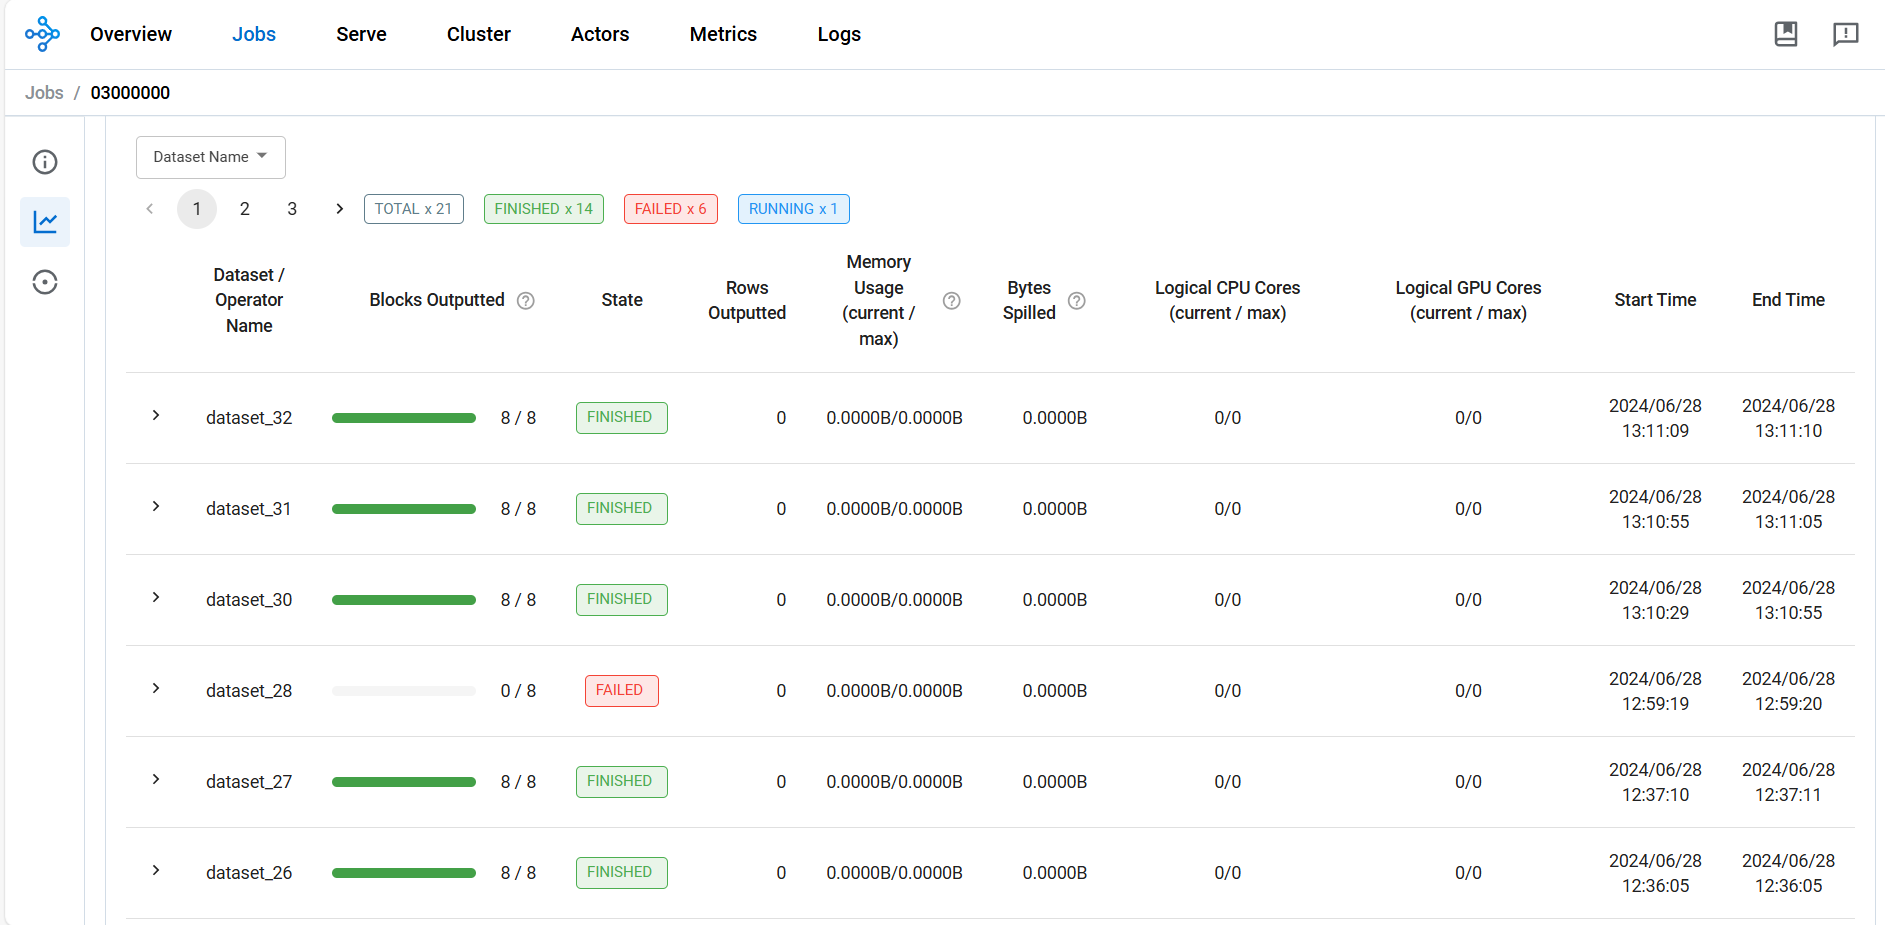

# Feature Scaling

In [32]:
feature_ds = ray.data.from_pandas(df_lagged)

In [33]:
# List of columns to scale
cols_to_scale = [
    "Temperature_mean", "Humidity_mean", "WindSpeed_mean", 
    "GeneralDiffuseFlows_mean", "DiffuseFlows_mean", "PowerConsumption_Zone1_sum", "PowerConsumption_Zone2_sum", "PowerConsumption_Zone3_sum", 
    "Temperature_mean_lag4", "Temperature_mean_lag8", "Temperature_mean_lag12", "Temperature_mean_lag24", "Temperature_mean_lag48", 
    "Humidity_mean_lag4", "Humidity_mean_lag8", "Humidity_mean_lag12", "Humidity_mean_lag24", "Humidity_mean_lag48",
    "WindSpeed_mean_lag4", "WindSpeed_mean_lag8", "WindSpeed_mean_lag12", "WindSpeed_mean_lag24", "WindSpeed_mean_lag48", 
    "GeneralDiffuseFlows_mean_lag4", "GeneralDiffuseFlows_mean_lag8", "GeneralDiffuseFlows_mean_lag12", "GeneralDiffuseFlows_mean_lag24", "GeneralDiffuseFlows_mean_lag48",
    "DiffuseFlows_mean_lag4", "DiffuseFlows_mean_lag8", "DiffuseFlows_mean_lag12", "DiffuseFlows_mean_lag24", "DiffuseFlows_mean_lag48", 
    "PowerConsumption_Zone1_sum_lag4", "PowerConsumption_Zone1_sum_lag8", "PowerConsumption_Zone1_sum_lag12", "PowerConsumption_Zone1_sum_lag24", "PowerConsumption_Zone1_sum_lag48",
    "PowerConsumption_Zone2_sum_lag4", "PowerConsumption_Zone2_sum_lag8", "PowerConsumption_Zone2_sum_lag12", "PowerConsumption_Zone2_sum_lag24", "PowerConsumption_Zone2_sum_lag48", 
    "PowerConsumption_Zone3_sum_lag4", "PowerConsumption_Zone3_sum_lag8", "PowerConsumption_Zone3_sum_lag12", "PowerConsumption_Zone3_sum_lag24",  "PowerConsumption_Zone3_sum_lag48"
]


In [34]:
cols_to_scale

['Temperature_mean',
 'Humidity_mean',
 'WindSpeed_mean',
 'GeneralDiffuseFlows_mean',
 'DiffuseFlows_mean',
 'PowerConsumption_Zone1_sum',
 'PowerConsumption_Zone2_sum',
 'PowerConsumption_Zone3_sum',
 'Temperature_mean_lag4',
 'Temperature_mean_lag8',
 'Temperature_mean_lag12',
 'Temperature_mean_lag24',
 'Temperature_mean_lag48',
 'Humidity_mean_lag4',
 'Humidity_mean_lag8',
 'Humidity_mean_lag12',
 'Humidity_mean_lag24',
 'Humidity_mean_lag48',
 'WindSpeed_mean_lag4',
 'WindSpeed_mean_lag8',
 'WindSpeed_mean_lag12',
 'WindSpeed_mean_lag24',
 'WindSpeed_mean_lag48',
 'GeneralDiffuseFlows_mean_lag4',
 'GeneralDiffuseFlows_mean_lag8',
 'GeneralDiffuseFlows_mean_lag12',
 'GeneralDiffuseFlows_mean_lag24',
 'GeneralDiffuseFlows_mean_lag48',
 'DiffuseFlows_mean_lag4',
 'DiffuseFlows_mean_lag8',
 'DiffuseFlows_mean_lag12',
 'DiffuseFlows_mean_lag24',
 'DiffuseFlows_mean_lag48',
 'PowerConsumption_Zone1_sum_lag4',
 'PowerConsumption_Zone1_sum_lag8',
 'PowerConsumption_Zone1_sum_lag12',
 'Po

In [35]:
# Convert the DataFrame to a Ray Dataset
ds = ray.data.from_pandas(df_lagged)

# Define a function to apply MinMaxScaler to a pandas DataFrame
def scale_partition(df, cols_to_scale):
    scaler = MinMaxScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    return df

# Use Ray's map_batches to apply the scaling function across partitions
# map_batches expects a function that operates on pandas DataFrames (or Arrow tables)
scaled_ds = feature_ds.map_batches(lambda batch: scale_partition(batch, cols_to_scale), batch_format="pandas")

# Optionally, convert the scaled Ray Dataset back to a pandas DataFrame
scaled_df = scaled_ds.to_pandas()

2024-09-01 19:34:47,217	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-01_19-09-54_637042_4122/logs/ray-data
2024-09-01 19:34:47,220	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)]


In [36]:
scaled_df.head()

,Year,Month,Day,Hour,Temperature_mean,Humidity_mean,WindSpeed_mean,GeneralDiffuseFlows_mean,DiffuseFlows_mean,PowerConsumption_Zone1_sum,...,PowerConsumption_Zone2_sum_lag4,PowerConsumption_Zone2_sum_lag8,PowerConsumption_Zone2_sum_lag12,PowerConsumption_Zone2_sum_lag24,PowerConsumption_Zone2_sum_lag48,PowerConsumption_Zone3_sum_lag4,PowerConsumption_Zone3_sum_lag8,PowerConsumption_Zone3_sum_lag12,PowerConsumption_Zone3_sum_lag24,PowerConsumption_Zone3_sum_lag48
0,2017,1,1,0,0.166667,0.723684,0.0,0.0,0.0,0.472844,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,2017,1,1,1,0.125000,0.765789,0.0,0.0,0.0,0.328443,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,2017,1,1,2,0.093750,0.784211,0.0,0.0,0.0,0.246585,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,2017,1,1,3,0.104167,0.755263,0.0,0.0,0.0,0.206128,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,2017,1,1,4,0.104167,0.710526,0.0,0.0,0.0,0.195475,...,0.609856,0.0,0.0,0.0,0.0,0.69688,0.0,0.0,0.0,0.0


# Saving the transformed dataset to the local filesytem

In [37]:
# First save the data in the transformed data directory as CSV
scaled_df.to_csv('2-transformed-data/transformed_features.csv')

# Storing the transformed data to the feature store 
You may wonder why do we even need a feature store in the first place, where we can just save the transformed dataset locally and import directly from there to train the model. 

You may find the answer for that in the next notebook ***"2.training-and-saving-the-model.ipynb"***

In [41]:
scaled_ds.write_csv("s3://featurestorebucket-poridhi-12345-5bd4639/feature_data.csv")

2024-06-28 15:24:04,813	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-06-28_13-39-03_152976_1135/logs/ray-data
2024-06-28 15:24:04,815	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Write]


- Write 1:   0%|                                                                        | 0/1 [00:00<?, ?it/s]

Running 0:   0%|                                                                        | 0/1 [00:00<?, ?it/s]

You may find the transformed file in your respective s3 bucket being used as feature store
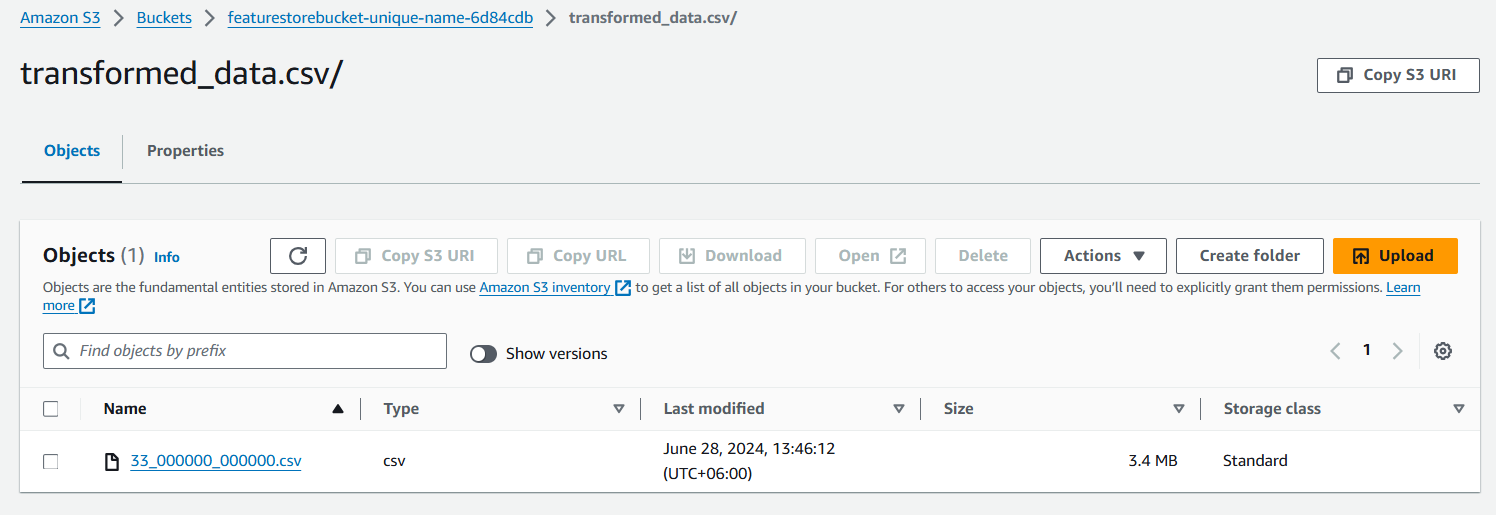

## Matplotlib Plots

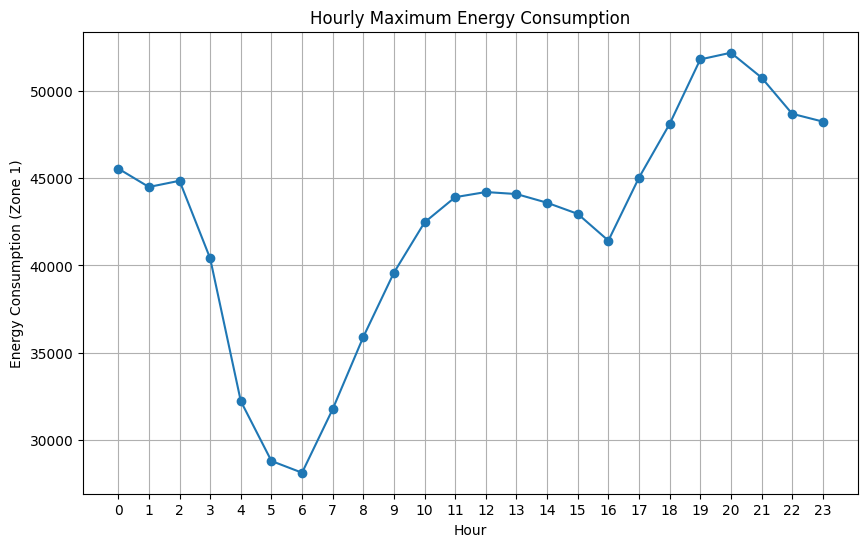

In [137]:
# Calculate the hourly maximum energy consumption
hourly_max = df_updated.groupby('Hour')['PowerConsumption_Zone1'].max().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_max['Hour'], hourly_max['PowerConsumption_Zone1'], marker='o')
plt.title('Hourly Maximum Energy Consumption')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption (Zone 1)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## Plotly Plots

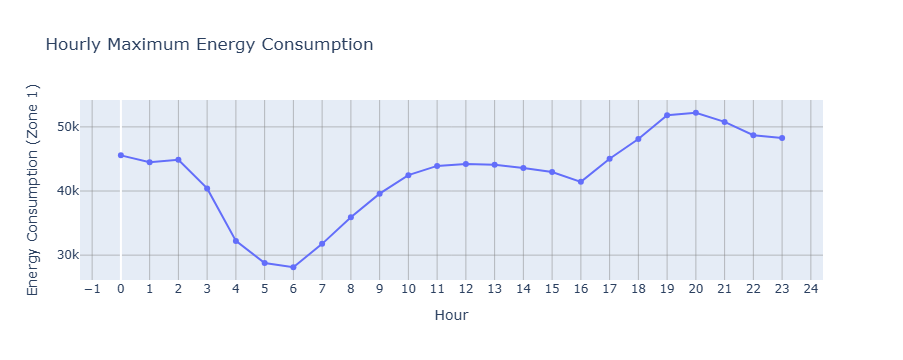

In [138]:
import plotly.express as px

# Assuming hourly_max DataFrame is already created as per your code

# Create the plot with Plotly Express
fig = px.line(hourly_max, x='Hour', y='PowerConsumption_Zone1', markers=True,
              title='Hourly Maximum Energy Consumption',
              labels={'PowerConsumption_Zone1': 'Energy Consumption (Zone 1)'})

# Customize the layout for grid and ticks
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        title='Hour',
        gridcolor='grey',  # Customize grid line color
        gridwidth=0.5  # Customize grid line width
    ),
    yaxis=dict(
        title='Energy Consumption (Zone 1)',
        gridcolor='grey',  # Customize grid line color
        gridwidth=0.5  # Customize grid line width
    ),
    showlegend=False
)

# Show the plot
fig.show()

## Observing Monthly Energy Consumption

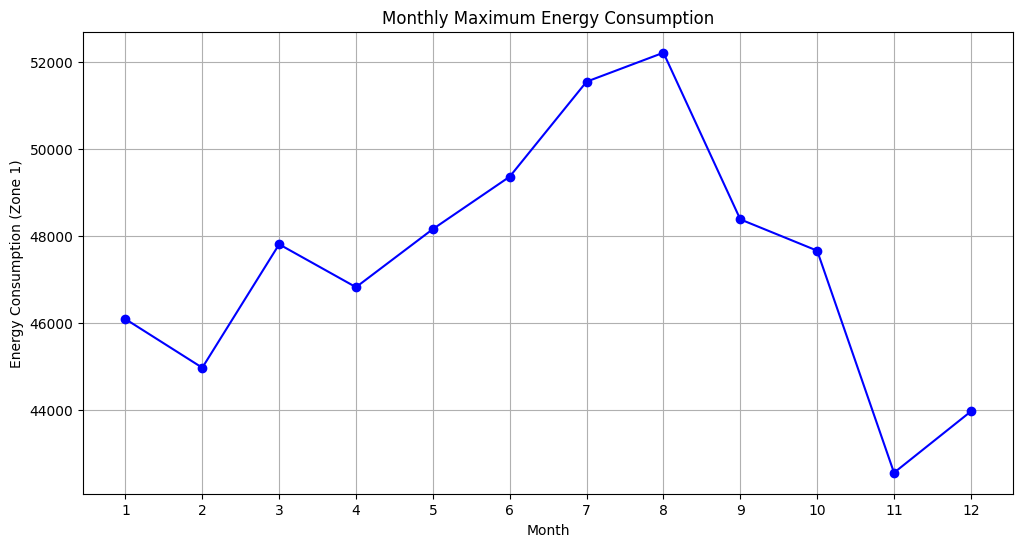

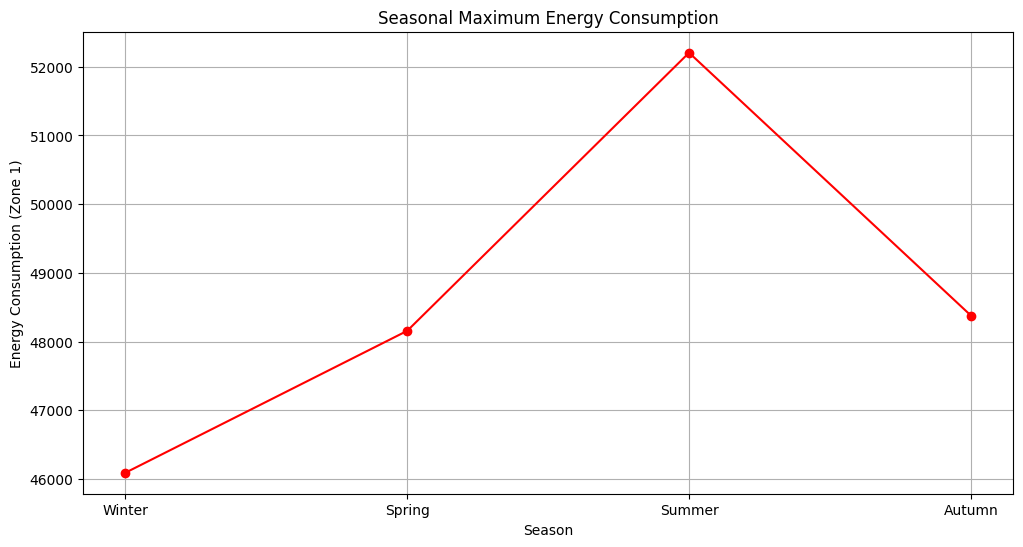

In [139]:
# Monthly maximum energy consumption
monthly_max = df_updated.groupby('Month')['PowerConsumption_Zone1'].max().reset_index()

# Seasonal maximum energy consumption
seasonal_max = df_updated.groupby('Season')['PowerConsumption_Zone1'].max().reset_index()

# To display seasons in order
seasonal_max['Season'] = pd.Categorical(seasonal_max['Season'], categories=['Winter', 'Spring', 'Summer', 'Autumn'], ordered=True)
seasonal_max = seasonal_max.sort_values('Season')

# Plot for monthly maximum energy consumption
plt.figure(figsize=(12, 6))
plt.plot(monthly_max['Month'], monthly_max['PowerConsumption_Zone1'], marker='o', linestyle='-', color='b')
plt.title('Monthly Maximum Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (Zone 1)')
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

# Plot for seasonal maximum energy consumption
plt.figure(figsize=(12, 6))
plt.plot(seasonal_max['Season'], seasonal_max['PowerConsumption_Zone1'], marker='o', linestyle='-', color='r')
plt.title('Seasonal Maximum Energy Consumption')
plt.xlabel('Season')
plt.ylabel('Energy Consumption (Zone 1)')
plt.grid(True)
plt.show()

## Key Findings:
It can be clearly observed that, summer has the highest energy consumption among the seasons. And, it's quite obvious that the households need more appliances like air conditioners during that season in that part of the world where summer is generally hot. The trend can be quite opposite in countries of different continent where winter is more energy consuming season. 